# Classifying Moons Data
### This Project aims to study how various Machine Learning models perform with the moons data. The moons data consists of two classes that has the chape of two crescent moons intervening each other (see below).
### The models To be tested are the following


In [491]:
import sklearn
import numpy as np


In [492]:
# just some code to beautify the plots
import matplotlib.pyplot as plt
from pathlib import Path

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# This Code will save the figures
IMAGES_PATH = Path() / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=500):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Creating the dataset

In [493]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=2500, noise=0.2, random_state=7)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=7) 

#### Pretty Nice!
We now have moons data with number of instances = 250 and some gaussian noise. Let's Visualize it. 

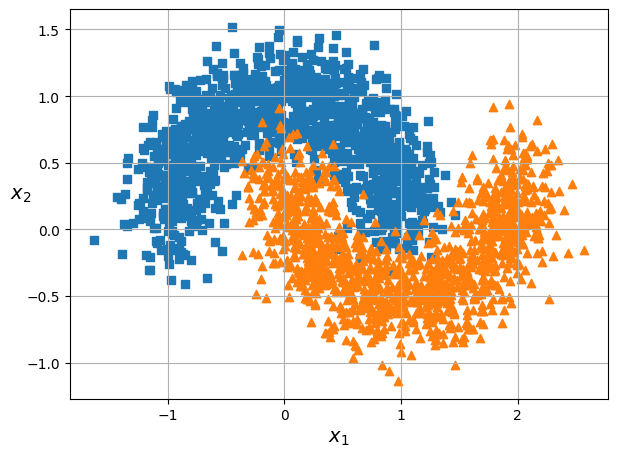

In [494]:
plt.scatter(X[:,0][y==0], X[:,1][y==0], marker="s")
plt.scatter(X[:,0][y==1], X[:,1][y==1], marker="^")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.grid(True)
save_fig("Moons Data noise=0.2")
plt.show()

In [495]:
import pandas as pd


Models = pd.DataFrame({
    "Model":[],
    "Train_Acc":[],
    "Test_Acc":[],
})

Models.set_index(["Model"], inplace=True)

In [496]:
from sklearn.metrics import accuracy_score

def acc(model):
    return [accuracy_score(model.predict(X_train), y_train),
                           accuracy_score(model.predict(X_test), y_test)]

## Training ML models
Various ML models and their scores will be tested, different models might require different preprocessing to the data to make it perform better, such preprocessing will be done as we go.

## 1) Logistic Regression Model

In [497]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C=50, random_state=7)
log_reg.fit(X_train, y_train)



LogisticRegression(C=50, random_state=7)

In [498]:
from sklearn.model_selection import cross_val_score

cross_val_score(log_reg, X_train, y_train, scoring="accuracy", cv=3)

array([0.85007496, 0.87106447, 0.86636637])

### Now let's look at the Accuracy of this model

In [499]:
Models.loc["Logistic_Regression"] = acc(log_reg)
Models

,Train_Acc,Test_Acc
Model,,
Logistic_Regression,0.8615,0.864


### Not so bad! a visualization of the mis_classified instances may help understand why did we get such an accuracy.

In [500]:
def plot_mis_classified_instances(model,name="model's", save=False):
    mis_clf_instances = X_train[:][y_train!=model.predict(X_train)]
    
    plt.scatter(X[:,0][y==0], X[:,1][y==0], marker="s")
    plt.scatter(X[:,0][y==1], X[:,1][y==1], marker="^")
    plt.scatter(mis_clf_instances[:,0], mis_clf_instances[:,1], color="red")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)
    plt.grid(True)
    plt.title(name+" mis_classified instances")
    if save:
        save_fig("mis_clf "+name)

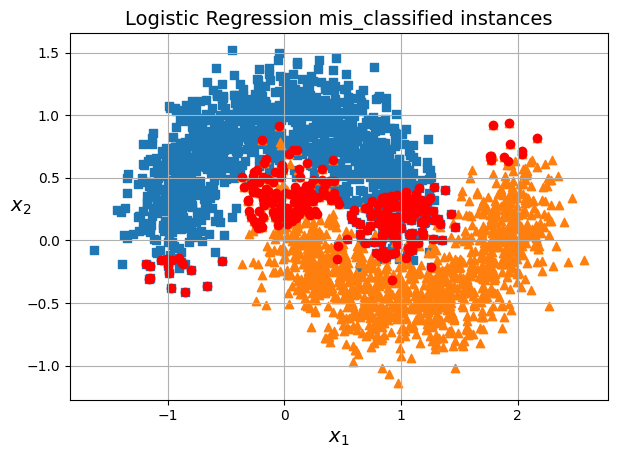

In [501]:
plot_mis_classified_instances(log_reg, "Logistic Regression",True)

### Not Surprising at all! Such a pattern is because Logistic Regression uses Linear regression to draw a line that minimizes the cost function, such a model is not reliable for such a dataset.
### To account for the non_linearity in the dataset, we may use the PolynomialFeatures Preprocessor to add features that can be used to classify instances with the Logistic Regression Classifier.

In [502]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

log_reg_poly = make_pipeline(PolynomialFeatures(degree=5),
                             LogisticRegression(random_state=7))

log_reg_poly.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=5)),
                ('logisticregression', LogisticRegression(random_state=7))])

In [503]:
Models.loc["Polynomial Logistic Regression"] = acc(log_reg_poly)
Models

,Train_Acc,Test_Acc
Model,,
Logistic_Regression,0.8615,0.864
Polynomial Logistic Regression,0.9725,0.970


### An Accuracy of 0.97 on the testing set, What an improvement!

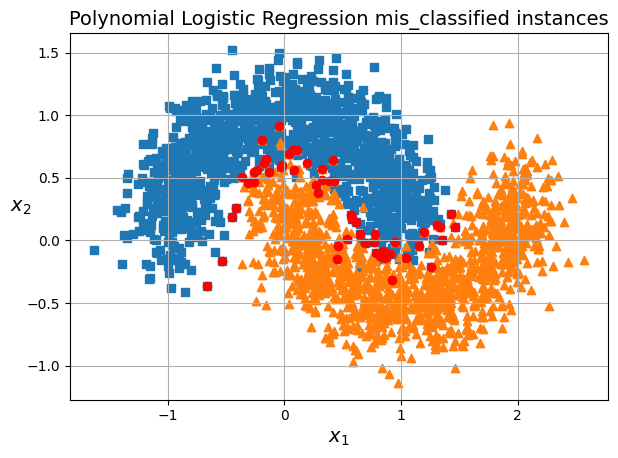

In [504]:
plot_mis_classified_instances(log_reg_poly,"Polynomial Logistic Regression", True)

## 2) SVM Classifier
#### Support Vector Machines (SVM) also produce linear classifications such as Logistic Regression, however, svm have a kernel attribute that can add polynomial features

In [505]:
from sklearn.svm import SVC

svc_clf = SVC(kernel="poly", coef0=1, degree=5, C=5, tol=1e-5)
svc_clf.fit(X_train, y_train)

SVC(C=5, coef0=1, degree=5, kernel='poly', tol=1e-05)

In [506]:
Models.loc["SVC with a Polynomial Kernel"] = acc(svc_clf)
Models

,Train_Acc,Test_Acc
Model,,
Logistic_Regression,0.8615,0.864
Polynomial Logistic Regression,0.9725,0.970
SVC with a Polynomial Kernel,0.9780,0.974


### We can see that SVC model Performed a little bit better than the previous model

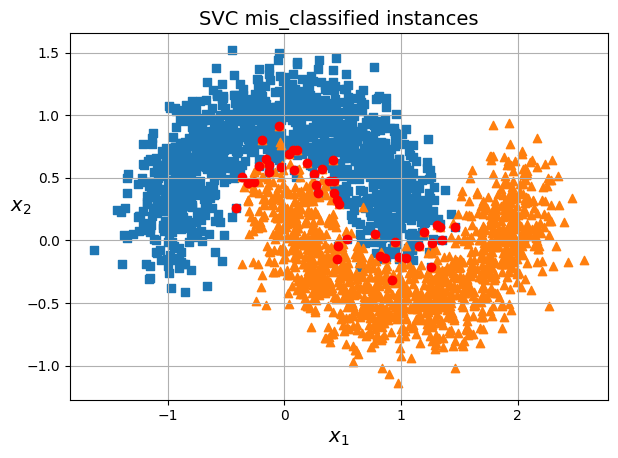

In [507]:
plot_mis_classified_instances(svc_clf, "SVC", True)

### Maybe SVC can perform better with Scaling

In [508]:
from sklearn.preprocessing import StandardScaler

svc_clf_scaled = make_pipeline(StandardScaler(),
                              SVC(kernel="poly", coef0=1, degree=5, C=5, tol=1e-5))
svc_clf_scaled.fit(X_train, y_train)
acc(svc_clf_scaled)

[0.979, 0.974]

Not that much!

## 3) Decision Trees

In [509]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(min_samples_leaf=10 ,random_state=7)
tree_clf.fit(X_train,y_train)

DecisionTreeClassifier(min_samples_leaf=10, random_state=7)

In [510]:
tree_clf.tree_.max_depth

8

In [511]:
Models.loc["Decision Tree Classifier"] = acc(tree_clf)
Models

,Train_Acc,Test_Acc
Model,,
Logistic_Regression,0.8615,0.864
Polynomial Logistic Regression,0.9725,0.970
SVC with a Polynomial Kernel,0.9780,0.974
Decision Tree Classifier,0.9805,0.976


### The DecisionTreeClassifier didn't do any better than the previous one, and although it performed a little better on the testing set (accuracy of 0.974) than the secd Classifier (accuracy of 0.972), it seems that the Decision tree Classifier had overfitted the training data a little bit (train_acc=0.981, test_acc=0.974).

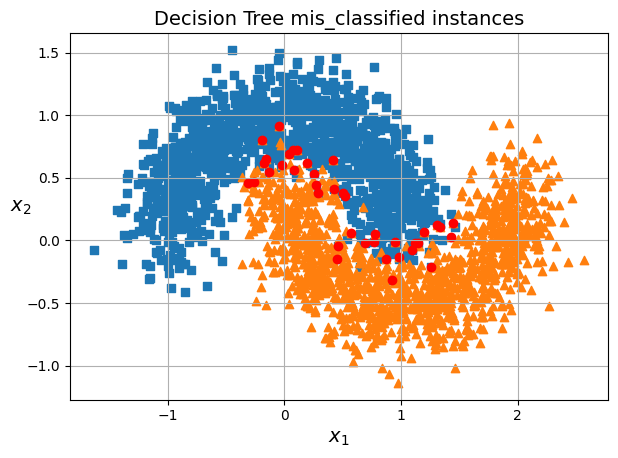

In [512]:
plot_mis_classified_instances(tree_clf,"Decision Tree", True)

## 4) Random Forest Classifier

In [513]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=500, min_samples_leaf=10, max_depth=7, n_jobs=-1, random_state=7)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, min_samples_leaf=10, n_estimators=500,
                       n_jobs=-1, random_state=7)

In [514]:
Models.loc["Random Forest Classifier"] = acc(forest_clf)
Models

,Train_Acc,Test_Acc
Model,,
Logistic_Regression,0.8615,0.864
Polynomial Logistic Regression,0.9725,0.970
SVC with a Polynomial Kernel,0.9780,0.974
Decision Tree Classifier,0.9805,0.976
Random Forest Classifier,0.9830,0.970


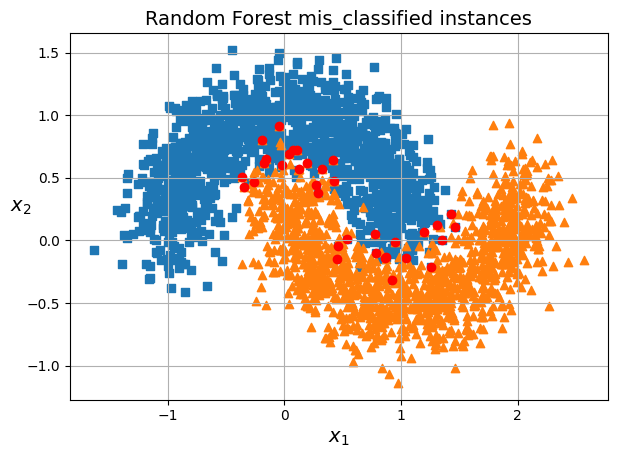

In [515]:
plot_mis_classified_instances(forest_clf, "Random Forest", True)

### Just as with the decision tree classifier, not that much improvement and a little bit overfitting, not surprising since the random forest is just a stack of decision trees (500 in this case) and the predicted class is the mode.
### Randomized Search for the best parameters for this model might help

In [516]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

forest_rnd_search = RandomizedSearchCV(RandomForestClassifier(),
                                      param_distributions={
                                          "min_samples_leaf": randint(low=1, high=7),
                                          "max_depth": randint(low=3, high=9)
                                      }, scoring="accuracy", cv=3,
                                       n_iter=20, random_state=7)
forest_rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002992BDF9750>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002992BDF9540>},
                   random_state=7, scoring='accuracy')

In [517]:
forest_rnd_search.best_params_

{'max_depth': 7, 'min_samples_leaf': 2}

In [518]:
acc(forest_rnd_search)

[0.987, 0.974]

### It sure perform a little bit better now, but the proplem of a  little bet overfitting is clear, this can be cured by regularizing the model by restricting it's parameters to a value that generalizes the model, but for now, these numbers are good to work with.

## 5) 

In [519]:
from sklearn.neighbors import KNeighborsClassifier

kng_rnd_search = RandomizedSearchCV(KNeighborsClassifier(),
                             param_distributions={
                                 "leaf_size": randint(low=10, high=50),
                                 "p": randint(low=1, high=5)
                             }, scoring="accuracy", cv=3,
                             n_jobs=-1, random_state=7)
kng_rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'leaf_size': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002992DE2FE80>,
                                        'p': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000029931DC9570>},
                   random_state=7, scoring='accuracy')

In [521]:
kng_rnd_search.best_params_

{'leaf_size': 13, 'p': 4}

In [522]:
acc(kng_clf)

[0.9785, 0.98]

In [523]:
kng_clf = KNeighborsClassifier()
kng_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [524]:
Models.loc["KNeighbors Classifier"] = acc(kng_clf)
Models

,Train_Acc,Test_Acc
Model,,
Logistic_Regression,0.8615,0.864
Polynomial Logistic Regression,0.9725,0.970
SVC with a Polynomial Kernel,0.9780,0.974
Decision Tree Classifier,0.9805,0.976
Random Forest Classifier,0.9830,0.970
KNeighbors Classifier,0.9810,0.980


## By comparing this result to the one given by the random search, it's obvious that all the random search did was to overfit the data, not improving the overall performance of the model.

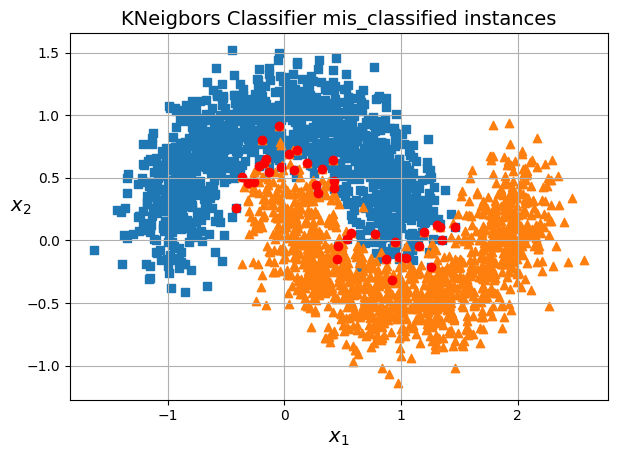

In [525]:
plot_mis_classified_instances(kng_clf, "KNeigbors Classifier", True)

## Final Notes
### The performance of the model depend strongly on the data and the noiseness of the data passed to the model
### For example, the dataset used has a gaussian noise with std=0.2, if the standard deviation of this noise has a smaller value (0.1 for example) this will lead to a much better predictions

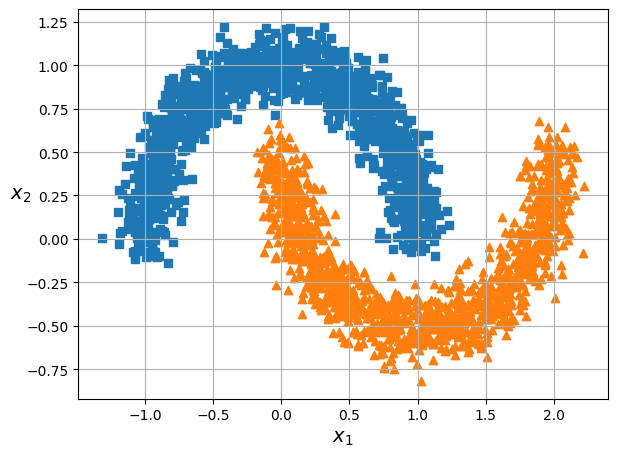

In [526]:
Xnew, ynew = make_moons(n_samples=2500, noise=0.1, random_state=7)

Xnew_train, Xnew_test, ynew_train, ynew_test = train_test_split(Xnew, ynew,test_size=0.2, random_state=7)

plt.scatter(Xnew[:,0][ynew==0], Xnew[:,1][ynew==0], marker="s")
plt.scatter(Xnew[:,0][ynew==1], Xnew[:,1][ynew==1], marker="^")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.grid(True)
save_fig("Moons Data noise=0.1")
plt.show()

In [527]:
log_reg_poly_new = make_pipeline(PolynomialFeatures(degree=5),
                             LogisticRegression(random_state=7))
log_reg_poly_new.fit(Xnew_train,ynew_train)

kng_new = KNeighborsClassifier()
kng_new.fit(Xnew_train,ynew_train)

KNeighborsClassifier()

In [528]:
print("Test accuracy _ Polynomial Logistic Regression   "+ str(accuracy_score(log_reg_poly_new.predict(Xnew_test), ynew_test)))
print("Test accuracy _ Kneigbors Classifier             "+ str(accuracy_score(kng_new.predict(Xnew_test), ynew_test)))                       

Test accuracy _ Polynomial Logistic Regression   0.998
Test accuracy _ Kneigbors Classifier             1.0


### The KNeigbors Classifier didn't even get one wrong Prediction.